#### Overview
- Reproducing https://medium.com/@dave.cote.msc/hybrid-multimodal-neural-network-architecture-combination-of-tabular-textual-and-image-inputs-7460a4f82a2e
- This script uses a transfer-learned Logistic Regression model (from VGG16 modelas a feature extractor) to predict every image we have into "good" or "bad" images
- Output: img_pred_bad.csv
- Rows with "bad" images in the tabular data will be removed

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import pickle

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

# other imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

2023-07-21 07:22:53.649065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 07:22:57.318206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 07:22:57.319884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 07:23:02.024567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#User Input 
config={
  "feature_extractor_model" : "vgg16",
  "weights"         : "imagenet",
  "include_top"     : False,
  "classifier_model": "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/classifier.pickle",
  "pred_path"       : "/workspaces/deeplearning-multimodal-neural-network/data/homeimages/",
  "results"         : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/results.csv",
  "image_size"      : (224, 224)
}

In [7]:
# config variables
feature_extractor_model = config["feature_extractor_model"]
feature_extractor_weights = config["weights"]
classifier_model = config["classifier_model"]
pred_path = config["pred_path"]
results_path = config["results"]

if feature_extractor_model == "vgg16":
    base_model = VGG16(weights=feature_extractor_weights)#, include_top=True)
    fe_model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
    image_size = (224, 224)
else:
    base_model = None

print ("Successfully loaded base model and model...")

2023-07-21 07:24:21.520130: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-21 07:24:21.829337: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-21 07:24:21.969042: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-21 07:24:22.235462: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-07-21 07:24:22.275850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


Successfully loaded base model and model...


#### Preprocess images for prediction, and the prediction

In [8]:
#Load previously trained model
tl_model = pickle.load(open(classifier_model, 'rb'))

In [17]:
l_images = os.listdir(pred_path)
img = image.load_img(pred_path + l_images[7], target_size=image_size) #224x224
a_img = image.img_to_array(img) #50176
a_img = np.expand_dims(a_img, axis=0)
a_img = preprocess_input(a_img)
print(a_img.shape)
feature = fe_model.predict(a_img)
print(feature.shape)
pred = tl_model.predict(feature)



(1, 224, 224, 3)
1/1 [==============================] - 0s 182ms/step
(1, 4096)


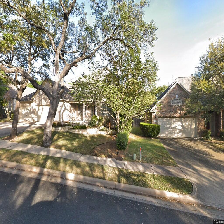

In [18]:
img

In [19]:
pred

array([0])

In [9]:
#variable to hold processed images
l_preds = []

#loop over all the labels in the folder
l_images = os.listdir(pred_path)
for filename in l_images:
    img = image.load_img(pred_path + filename, target_size=image_size) #(1, 224, 224, 3)
    #img = image.load_img(pred_path + filename, color_mode='grayscale', target_size=image_size) #224x224
    a_img = image.img_to_array(img) #(224, 224, 3)
    # 't' is a tensor of shape [2], tf.shape(tf.expand_dims(t, 0))  # [1, 2] | https://ai-mrkogao.github.io/tensorflow/tfexpanddims/
    a_img = np.expand_dims(a_img, axis=0) #(1, 224, 224, 3)
    a_img = preprocess_input(a_img)
    feature = fe_model.predict(a_img)
    #a_img = a_img.flatten()
    # #Prediction
    pred = tl_model.predict(feature)
    l_preds.append(pred)


1/1 [==============================] - 0s 177ms/step


: 

: 

In [ ]:
#Combine two lists into a dataframe
df_img_pred = pd.DataFrame({'filename':l_images,
                            'prediction': l_preds
                            })

df_img_pred.to_csv(results_path, sep=',', index=False)
